# Controlling the chatbot memory

We follow the [langgraph tutorial](https://langchain-ai.github.io/langgraph/tutorials/introduction/) to learn the basics about memory by building a simple chatbot.

So far, we have been prototyping chatbots that do not have any memory of previous messages in context.
Here, we will explore how to keep a memory in two ways, and how to use it to rewind and branch off from different points in the conversation.

# Build a basic chatbot

By now, we know how to build a simple chatbot.
We will keep it as simple as possible (without tools) to be able to focus on the memory part.

In [ ]:
from typing import Annotated

from dotenv import load_dotenv
from langchain.chat_models import init_chat_model
from langgraph.graph import END, START, StateGraph
from langgraph.graph.message import add_messages
from typing_extensions import TypedDict

from IPython.display import Image, display

load_dotenv()
llm = init_chat_model(model="anthropic:claude-3-5-sonnet-latest")

The graph will take a user input, pass it to the LLM, and directly return the response.

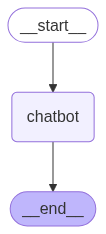

In [ ]:
class State(TypedDict):
    # The state contains the message history: a list that we change with the add_messages function
    # New messages are appended to the list, rather than replacing the previous ones.
    messages: Annotated[list, add_messages]


def chatbot(state: State) -> State:
    return {"messages": [llm.invoke(state["messages"])]}


graph_builder = StateGraph(State)
graph_builder.add_node("chatbot", chatbot)
graph_builder.add_edge(START, "chatbot")
graph_builder.add_edge("chatbot", END)

graph = graph_builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

# Manually handle the state

The state contains the message history.
The simplest way to implement a memory for our chatbot is by manually handling the state between interactions in our chat loop.

In [ ]:
state = {"messages": []}

while True:
    user_input = input("User: ")
    if user_input.lower() in ["quit", "exit", "q"]:
        print("Goodbye!")
        break

    state["messages"] = state.get("messages", []) + [{"role": "user", "content": user_input}]
    state = graph.invoke(state)

    print("User:", user_input)
    if state.get("messages") and len(state["messages"]) > 0:
        print("Assistant:", state["messages"][-1].content)  # Print the last message
        print("\n")

User: Hi, my name's Borja. Nice to meet you!
Assistant: Hi Borja! Nice to meet you too! I'm Claude, an AI assistant created by Anthropic. How can I help you today?


User: Could you write a word starting with every letter in my name?
Assistant: Here are words starting with each letter in "BORJA":

B - Beautiful
O - Organic
R - Radiant
J - Jovial
A - Adventurous


User: Thanks, that was great!
Assistant: You're welcome, Borja! Glad I could help! Let me know if you'd like to try anything else 😊


Goodbye!


In every pass of the loop, we add the user input to the current state, and then get the new state by invoking the graph.
This allows the LLM to keep the previous interactions in context and have a coherent conversation.
In this case, we first give the chatbot a name, and then ask it to perform a task with the name without repeating it.
Without a memory, the task would be impossible to do!

# Checkpointing

LangGraph offers functionality to checkpoint the state at every step in the conversation.
To do so, we need to provide a `checkpointer` when compiling the graph, as well as an ID for the thread when calling it.

Checkpointing this way is much more powerful than simply keeping a chat memory.
It will allow us to move freely along the conversation, restart it from any given point, branch off separate threads, etc.

In [ ]:
from langgraph.checkpoint.memory import MemorySaver  # noqa: E402

memory = MemorySaver()
# This memory saver keeps the checkpointing in memory. In production, we'd use
# a checkpointer that connects to a database.

graph = graph_builder.compile(checkpointer=memory)  # Compile the graph with a checkpointer

Now to use this graph, we need to provide it with a configuration that contains the thread ID.
**The thread ID should be a string!!!**
Apparently, it is converted into string internally and we may get unexpected behaviours with mismatching namespaces.

In [ ]:
config = {"configurable": {"thread_id": "0"}}

Let's check how it works!

In [ ]:
while True:
    user_input = input("User: ")
    # Terminate the conversation with quit, exit or q
    if user_input.lower() in ["quit", "exit", "q"]:
        print("Goodbye!")
        break

    events = graph.stream(
        {"messages": [{"role": "user", "content": user_input}]}, config, stream_mode="values"
    )
    for event in events:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

Hi, my name's Borja. Nice to meet you!
================================== Ai Message ==================================

Hi Borja! Nice to meet you too! I'm Claude, an AI assistant. How can I help you today?


================================ Human Message =================================

Could you write a word starting with every letter in my name?
================================== Ai Message ==================================

I'll write a word for each letter in "BORJA":

B - Beautiful
O - Ocean
R - Rainbow
J - Journey
A - Adventure


================================ Human Message =================================

Thanks, that was great!
================================== Ai Message ==================================

You're welcome, Borja! That was a fun exercise! Let me know if you'd like to try something else. 😊


Goodbye!


In [ ]:
while True:
    user_input = input("User: ")
    # Terminate the conversation with quit, exit or q
    if user_input.lower() in ["quit", "exit", "q"]:
        print("Goodbye!")
        break

    events = graph.stream(
        {"messages": [{"role": "user", "content": user_input}]}, config, stream_mode="values"
    )
    for event in events:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

Hi, my name's Borja. Nice to meet you!
================================== Ai Message ==================================

Hi Borja! Nice to meet you too! I'm an AI assistant. How can I help you today?
================================ Human Message =================================

Could you write a word starting with every letter in my name?
================================== Ai Message ==================================

Here are words starting with each letter in "BORJA":

B - Beautiful
O - Ocean
R - Rainbow
J - Journey
A - Adventure
================================ Human Message =================================

Thanks, that was great!
================================== Ai Message ==================================

You're welcome, Borja! Glad I could help! Let me know if you need anything else 😊
Goodbye!


Great! We see the information about the name is kept across interactions.


## Switching threads

Let's try now creating a new thread.
New threads will be fresh conversations, and the previously checkpointed ones will be preserved.
Let's see the effect by asking the chatbot about the name we gave it. 

In [ ]:
question = "What is my name?"

In the new thread, the chatbot has no context.

In [ ]:
other_config = {"configurable": {"thread_id": "1"}}  # Other thread

events = graph.stream(
    {"messages": [{"role": "user", "content": question}]}, other_config, stream_mode="values"
)

for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

What is my name?
================================== Ai Message ==================================

I don't know your name. You haven't shared it with me. Would you like to tell me your name?


In the original thread, the question is answered without a problem.

In [ ]:
events = graph.stream(
    {"messages": [{"role": "user", "content": question}]},
    config,  # Back to the same thread
    stream_mode="values",
)

for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

What is my name?
================================== Ai Message ==================================

Your name is Borja.


## Checkpoints

What exactly are checkpoints?
We can inspect the graph's state for a given config (specific thread).
Let's look at the main thread's state.

In [ ]:
snapshot = graph.get_state(config)
snapshot

StateSnapshot(values={'messages': [HumanMessage(content="Hi, my name's Borja. Nice to meet you!", additional_kwargs={}, response_metadata={}, id='bd3b692c-0908-4de9-819f-65d9f14460e1'), AIMessage(content="Hi Borja! Nice to meet you too! I'm an AI assistant. How can I help you today?", additional_kwargs={}, response_metadata={'id': 'msg_017AbgQfaVPG4DUzc63eZ5hN', 'model': 'claude-3-5-sonnet-20241022', 'stop_reason': 'end_turn', 'stop_sequence': None, 'usage': {'cache_creation_input_tokens': 0, 'cache_read_input_tokens': 0, 'input_tokens': 21, 'output_tokens': 27, 'server_tool_use': None}, 'model_name': 'claude-3-5-sonnet-20241022'}, id='run--e6f74635-81ca-493b-a3ef-3721ea117206-0', usage_metadata={'input_tokens': 21, 'output_tokens': 27, 'total_tokens': 48, 'input_token_details': {'cache_creation': 0, 'cache_read': 0}}), HumanMessage(content='Could you write a word starting with every letter in my name?', additional_kwargs={}, response_metadata={}, id='62f726a3-6b76-46b5-8d86-cb01a7bce0

The checkpoint contains the full history of our interactions.
For example, we can print the full conversation even though it has been created in two separate sessions.

In [ ]:
for message in snapshot.values["messages"]:
    message.pretty_print()

================================ Human Message =================================

Hi, my name's Borja. Nice to meet you!
================================== Ai Message ==================================

Hi Borja! Nice to meet you too! I'm an AI assistant. How can I help you today?
================================ Human Message =================================

Could you write a word starting with every letter in my name?
================================== Ai Message ==================================

Here are words starting with each letter in "BORJA":

B - Beautiful
O - Ocean
R - Rainbow
J - Journey
A - Adventure
================================ Human Message =================================

Thanks, that was great!
================================== Ai Message ==================================

You're welcome, Borja! Glad I could help! Let me know if you need anything else 😊
================================ Human Message =================================

What is my name?
=======